# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.calibration.experiments.fine_amplitude import FineAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.805348258280108+0j), sigma=80, beta=-0.7028492760050781, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8053+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_over, angle_per_gate=target_angle, phase_offset=np.pi / 2)
amp_cal.set_experiment_options(add_sx=True)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

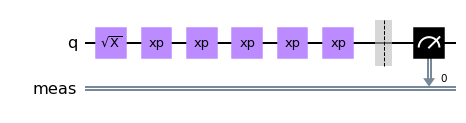

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

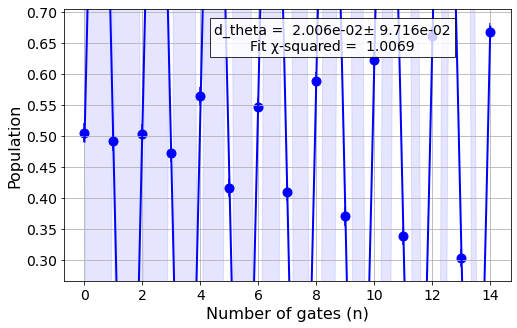

In [9]:
data_over = amp_cal.run(backend)

In [10]:
result = data_over.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-1.3359375 ,  0.02006033,  0.4908052 ]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([6.35945235e+00, 9.71575437e-02, 3.95394700e-03]),
 'pcov': array([[4.04426341e+01, 6.17851875e-01, 2.44651200e-03],
        [6.17851875e-01, 9.43958830e-03, 3.72416492e-05],
        [2.44651200e-03, 3.72416492e-05, 1.56336968e-05]]),
 'reduced_chisq': 1.0069450781635754,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_bad',
 'success': True}

In [11]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.020 rad.
Thus, scale the 0.8134+0.0000j pulse amplitude by 0.994 to obtain 0.80824+0.00000j.
Amplitude reported by the backend 0.8053+0.0000j.


### Detect an under-rotated pulse

In [12]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [13]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_under, angle_per_gate=target_angle, phase_offset=np.pi / 2)
amp_cal.set_experiment_options(add_sx=True)

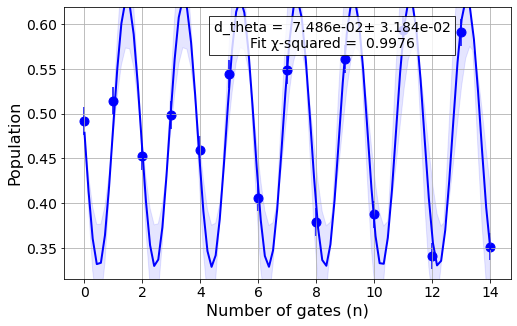

In [14]:
data_under = amp_cal.run(backend)

In [15]:
result = data_under.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([0.29962999, 0.07486417, 0.47858669]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.09804137, 0.03183614, 0.00400047]),
 'pcov': array([[ 9.61211067e-03, -3.08743509e-03,  4.19230762e-05],
        [-3.08743509e-03,  1.01353959e-03, -1.24127919e-05],
        [ 4.19230762e-05, -1.24127919e-05,  1.60037450e-05]]),
 'reduced_chisq': 0.9976209062147126,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [16]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.075 rad.
Thus, scale the 0.7973+0.0000j pulse amplitude by 0.977 to obtain 0.77874+0.00000j.
Amplitude reported by the backend 0.8053+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [17]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [18]:
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, phase_offset=0.0)
amp_cal.circuits(backend)[5].draw(output="mpl")
amp_cal.set_experiment_options(add_sx=False)

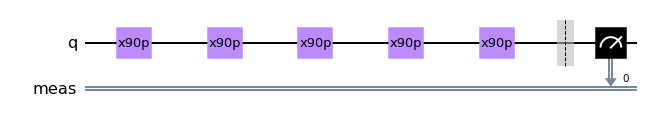

In [19]:
amp_cal.circuits(backend)[5].draw(output="mpl")

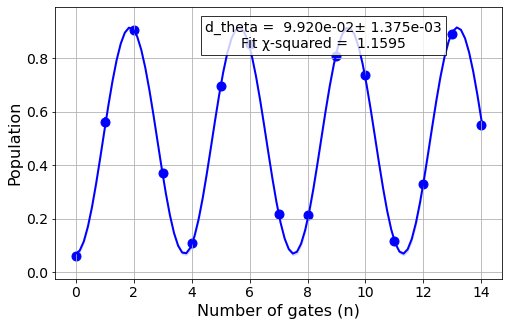

In [20]:
data_x90p = amp_cal.run(backend)

In [21]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.84710223,  0.09919892,  0.49215058]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00731329, 0.00137511, 0.00295003]),
 'pcov': array([[ 5.34841876e-05,  4.73666348e-07, -1.75277077e-06],
        [ 4.73666348e-07,  1.89092140e-06,  1.61546084e-07],
        [-1.75277077e-06,  1.61546084e-07,  8.70269492e-06]]),
 'reduced_chisq': 1.1594938797726513,
 'dof': 12,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [22]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.099 rad.
Thus, scale the 0.4027+0.0000j pulse amplitude by 0.941 to obtain 0.37875+0.00000j.
Amplitude reported by the backend 0.3701-0.0767j.
